In [16]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import pickle
import io
import imageio
from gymnasium import Env, spaces
from matplotlib.patches import Rectangle
from collections import defaultdict
from IPython.display import display, HTML, clear_output
import base64
# %pip install optuna
import optuna

Deterministic Environment

In [24]:
import random
import matplotlib.pyplot as plt
import numpy as np
import copy
import io
import imageio
from gymnasium import Env, spaces
from matplotlib.patches import Rectangle
from collections import defaultdict

class DeterministicWarehouseRobotEnv(Env):
    """
    A deterministic warehouse robot environment where the agent navigates a 6x6 grid to pick up
    packages and deliver them to a drop-off point, avoiding obstacles.
    Modified to prioritize multiple pickups by reducing the carrying penalty.
    """
    def __init__(self):
        super().__init__()
        
        # Environment setup
        self.grid_size = (6, 6)
        self.agent_pos = [0, 0]  # Starting position
        self.initial_packages = [[4, 5], [3, 3], [5, 5]]  # Package locations
        self.available_packages = copy.deepcopy(self.initial_packages)  # Packages to pick up
        self.dropped_packages = []  # Packages dropped off at non-destination locations
        self.delivered = 0  # Number of packages delivered to destination
        self.carrying = 0  # Number of packages currently carried
        self.dropoff_pos = [0, 4]  # Destination for packages
        self.obstacles = [[1, 1], [1, 2], [2, 1]]  # Obstacles (shelves)
        
        # Action space: Up (0), Down (1), Left (2), Right (3), Pickup (4), Dropoff (5)
        self.action_space = spaces.Discrete(6)
        
        # Observation space: (agent_pos, carrying, delivered)
        self.observation_space = spaces.Tuple((
            spaces.MultiDiscrete([6, 6]),  # Agent position (x, y)
            spaces.Discrete(4),           # Carrying (0-3 packages)
            spaces.Discrete(4)            # Delivered (0-3 packages)
        ))

    def reset(self):
        """Reset the environment to the initial state."""
        self.agent_pos = [0, 0]
        self.available_packages = copy.deepcopy(self.initial_packages)
        self.dropped_packages = []
        self.delivered = 0
        self.carrying = 0
        return self._get_obs(), {}

    def step(self, action):
        """Execute one step in the environment (deterministic)."""
        # Adjusted base reward to encourage carrying multiple packages
        reward = -1 - self.carrying  # Reduced penalty from -1 - 2 * self.carrying
        terminated = False

        # Movement actions (0-3)
        if action < 4:
            new_pos = self._move(action)
            if self._valid_pos(new_pos):
                self.agent_pos = new_pos
            else:
                reward -= 10  # Penalty for invalid move

        # Pickup action (4) - progressive rewards
        elif action == 4 and self.carrying < 3:
            if self.agent_pos in self.available_packages:
                self.available_packages.remove(self.agent_pos)
                self.carrying += 1
                reward += 20 + (10 * self.carrying)  # e.g. +30, +40, +50
            elif self.agent_pos in self.dropped_packages:
                self.dropped_packages.remove(self.agent_pos)
                self.carrying += 1
                reward += 5 + (5 * self.carrying)    # progressive recovery
            else:
                reward -= 15  # Penalty for invalid pickup

        # Dropoff action (5) - exponential rewards
        elif action == 5 and self.carrying > 0:
            if self.agent_pos == self.dropoff_pos:
                self.delivered += self.carrying
                reward += 40 * (2 ** self.carrying)
                if self.delivered >= 3:
                    terminated = True
                    reward += 200  # Completion bonus
            else:
                self.dropped_packages.append(self.agent_pos.copy())
                reward -= 20 * self.carrying  # Wrong-drop penalty
            self.carrying = 0

        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        """Get the current observation."""
        return (tuple(self.agent_pos), self.carrying, self.delivered)

    def _move(self, action):
        """Move the agent based on the action."""
        moves = {
            0: [1, 0],   # Up
            1: [-1, 0],  # Down
            2: [0, -1],  # Left
            3: [0, 1]    # Right
        }
        delta = moves[action]
        new_pos = [self.agent_pos[0] + delta[0], self.agent_pos[1] + delta[1]]
        return new_pos

    def _valid_pos(self, pos):
        """Check if a position is valid (within grid and not an obstacle)."""
        x, y = pos
        return 0 <= x < 6 and 0 <= y < 6 and pos not in self.obstacles

    def render(self):
        """Render the environment for visualization."""
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)

        # Draw grid
        for x in range(7):
            ax.axvline(x, color='k')
        for y in range(7):
            ax.axhline(y, color='k')

        # Draw obstacles
        for obs in self.obstacles:
            ax.add_patch(Rectangle((obs[1], obs[0]), 1, 1, facecolor='black'))

        # Draw packages
        for package in self.available_packages:
            ax.add_patch(Rectangle((package[1], package[0]), 1, 1, facecolor='green'))
        for package in self.dropped_packages:
            ax.add_patch(Rectangle((package[1], package[0]), 1, 1, facecolor='blue'))

        # Draw dropoff point
        ax.add_patch(Rectangle((self.dropoff_pos[1], self.dropoff_pos[0]), 1, 1, facecolor='yellow'))

        # Draw agent
        ax.add_patch(Rectangle((self.agent_pos[1], self.agent_pos[0]), 1, 1, facecolor='red'))
        ax.set_title(f"Carrying: {self.carrying}, Delivered: {self.delivered}")
        plt.show()

    def render_frame(self):
        """Render the environment to an image for video recording."""
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)

        # Draw grid
        for x in range(7):
            ax.axvline(x, color='k')
        for y in range(7):
            ax.axhline(y, color='k')

        # Draw obstacles
        for obs in self.obstacles:
            ax.add_patch(Rectangle((obs[1], obs[0]), 1, 1, facecolor='black'))

        # Draw packages
        for package in self.available_packages:
            ax.add_patch(Rectangle((package[1], package[0]), 1, 1, facecolor='green'))
        for package in self.dropped_packages:
            ax.add_patch(Rectangle((package[1], package[0]), 1, 1, facecolor='blue'))

        # Draw dropoff point
        ax.add_patch(Rectangle((self.dropoff_pos[1], self.dropoff_pos[0]), 1, 1, facecolor='yellow'))

        # Draw agent
        ax.add_patch(Rectangle((self.agent_pos[1], self.agent_pos[0]), 1, 1, facecolor='red'))
        ax.set_title(f"Carrying: {self.carrying}, Delivered: {self.delivered}")

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        img = plt.imread(buf)
        buf.close()
        return img

Stochastic Environment

In [12]:
class StochasticWarehouseRobotEnv(Env):
    def __init__(self, slip_probability=0.1):
        """
        slip_probability: When taking a movement action, the agent moves in the intended direction with probability 0.9
        and stays in the same block with probability (slip_probability), e.g., 0.1 (10%).
        """
        super().__init__()
        
        # Environment setup
        self.grid_size = (6, 6)
        self.agent_pos = [0, 0]  # Starting position
        self.initial_packages = [[4, 5], [3, 3], [5, 5]]  # Package locations
        self.available_packages = copy.deepcopy(self.initial_packages)  # Packages to pick up
        self.dropped_packages = []  # Packages dropped off at non-destination locations
        self.delivered = 0  # Number of packages delivered to destination
        self.carrying = 0  # Number of packages currently carried
        self.dropoff_pos = [0, 4]  # Destination for packages
        self.obstacles = [[1, 1], [1, 2], [2, 1]]  # Obstacles (shelves)
        
        # Stochasticity in movement: with probability (1 - slip_probability) the agent moves as intended,
        # and with probability slip_probability, the agent remains in the same block.
        self.slip_probability = slip_probability
        
        # Action space: 0: Up, 1: Down, 2: Left, 3: Right, 4: Pickup, 5: Dropoff
        self.action_space = spaces.Discrete(6)
        # Observation space: (agent_pos, carrying, delivered)
        self.observation_space = spaces.Tuple((
            spaces.MultiDiscrete([6, 6]),  # Agent position (x, y)
            spaces.Discrete(4),           # Carrying (0-3 packages)
            spaces.Discrete(4)            # Delivered (0-3 packages)
        ))

    def reset(self):
        """Reset the environment to the initial state."""
        self.agent_pos = [0, 0]
        self.available_packages = copy.deepcopy(self.initial_packages)
        self.dropped_packages = []
        self.delivered = 0
        self.carrying = 0
        return self._get_obs(), {}

    def step(self, action):
        """
        Movement actions (0-3) are stochastic:
            - With probability 0.9: agent moves as intended.
            - With probability (slip_probability): agent remains in the same block.
        Pickup (action 4) and Dropoff (action 5) remain deterministic.
        """
        reward = -1 - (2 * self.carrying)  # Base penalty + carrying cost
        terminated = False

        if action < 4:
            # Stochastic movement: with 90% probability move as intended; with 10% (or slip_probability) stay in place.
            if random.random() < (1 - self.slip_probability):
                new_pos = self._move(action)
            else:
                new_pos = self.agent_pos  # Slip: remain in the same block

            if self._valid_pos(new_pos):
                self.agent_pos = new_pos
            else:
                reward -= 10  # Penalty for invalid move

        elif action == 4 and self.carrying < 3:
            if self.agent_pos in self.available_packages:
                self.available_packages.remove(self.agent_pos)
                self.carrying += 1
                reward += 20 + (10 * self.carrying)  # Progressive rewards: +20, then +30, then +40
            elif self.agent_pos in self.dropped_packages:
                self.dropped_packages.remove(self.agent_pos)
                self.carrying += 1
                reward += 5 + (5 * self.carrying)      # Progressive recovery for dropped package
            else:
                reward -= 15  # Penalty for invalid pickup

        elif action == 5 and self.carrying > 0:
            if self.agent_pos == self.dropoff_pos:
                self.delivered += self.carrying
                reward += 40 * (2 ** self.carrying)  # Exponential delivery bonus
                if self.delivered >= 3:
                    terminated = True
                    reward += 200  # Completion bonus
            else:
                self.dropped_packages.append(self.agent_pos.copy())
                reward -= 20 * self.carrying  # Wrong-drop penalty
            self.carrying = 0

        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        """Return the current observation."""
        return (tuple(self.agent_pos), self.carrying, self.delivered)

    def _move(self, action):
        """Return new position given an action."""
        moves = {
            0: [1, 0],   # Up
            1: [-1, 0],  # Down
            2: [0, -1],  # Left
            3: [0, 1]    # Right
        }
        delta = moves[action]
        new_pos = [self.agent_pos[0] + delta[0], self.agent_pos[1] + delta[1]]
        return new_pos

    def _valid_pos(self, pos):
        """Return True if pos is within grid and not an obstacle."""
        x, y = pos
        return 0 <= x < 6 and 0 <= y < 6 and pos not in self.obstacles

    def render(self):
        """Render the environment to a window."""
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)

        # Draw grid lines
        for x in range(7):
            ax.axvline(x, color='k')
        for y in range(7):
            ax.axhline(y, color='k')

        # Draw obstacles
        for obs in self.obstacles:
            ax.add_patch(Rectangle((obs[1], obs[0]), 1, 1, facecolor='black'))

        # Draw packages (green) and dropped packages (blue)
        for package in self.available_packages:
            ax.add_patch(Rectangle((package[1], package[0]), 1, 1, facecolor='green'))
        for package in self.dropped_packages:
            ax.add_patch(Rectangle((package[1], package[0]), 1, 1, facecolor='blue'))

        # Draw dropoff point (yellow)
        ax.add_patch(Rectangle((self.dropoff_pos[1], self.dropoff_pos[0]), 1, 1, facecolor='yellow'))

        # Draw agent (red)
        ax.add_patch(Rectangle((self.agent_pos[1], self.agent_pos[0]), 1, 1, facecolor='red'))
        ax.set_title(f"Carrying: {self.carrying}, Delivered: {self.delivered}")
        plt.show()

    def render_frame(self):
        """Render the environment to an image (for video recording)."""
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)

        for x in range(7):
            ax.axvline(x, color='k')
        for y in range(7):
            ax.axhline(y, color='k')

        for obs in self.obstacles:
            ax.add_patch(Rectangle((obs[1], obs[0]), 1, 1, facecolor='black'))

        for package in self.available_packages:
            ax.add_patch(Rectangle((package[1], package[0]), 1, 1, facecolor='green'))
        for package in self.dropped_packages:
            ax.add_patch(Rectangle((package[1], package[0]), 1, 1, facecolor='blue'))

        ax.add_patch(Rectangle((self.dropoff_pos[1], self.dropoff_pos[0]), 1, 1, facecolor='yellow'))
        ax.add_patch(Rectangle((self.agent_pos[1], self.agent_pos[0]), 1, 1, facecolor='red'))
        ax.set_title(f"Carrying: {self.carrying}, Delivered: {self.delivered}")

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        img = plt.imread(buf)
        buf.close()
        return img

Q learning algorithm

In [13]:
def train_q_learning(env, episodes=2500, alpha=0.1, gamma=0.90, epsilon_decay=0.990):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards = []
    epsilons = []
    epsilon = 1.0
    max_steps = 1000  # Limit for steps per episode

    for episode in range(episodes):
        if episode % 100 == 0:
            print(f"Training Episode {episode + 1}/{episodes}")
        state, _ = env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])
            
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            state = next_state
            steps += 1

        rewards.append(total_reward)
        epsilons.append(epsilon)
        epsilon = max(epsilon * epsilon_decay, 0.01)
        
        if episode % 500 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 2, 1)
            plt.plot(rewards)
            plt.title("Training Progress")
            plt.xlabel("Episode")
            plt.ylabel("Total Reward")
            
            plt.subplot(1, 2, 2)
            plt.plot(epsilons)
            plt.title("Epsilon Decay")
            plt.xlabel("Episode")
            plt.ylabel("Epsilon Value")
            
            plt.tight_layout()
            plt.show()

    return Q, rewards, epsilons


In [21]:
def record_video_inline(env, Q, max_steps=100):
    """
    Record a video of the agent's performance and display it inline in a Jupyter Notebook.
    Handles image format conversion and suppresses video compatibility warnings.
    """
    frames = []
    state, _ = env.reset()
    
    for _ in range(max_steps):
        # Render current frame (returns float32 array in [0, 1] range)
        frame = env.render_frame()
        
        # Convert float32 [0, 1] to uint8 [0, 255]
        frame_uint8 = (frame * 255).astype(np.uint8)
        
        frames.append(frame_uint8)
        
        # Choose greedy action
        action = np.argmax(Q[state])
        
        # Step the environment
        next_state, _, done, _, _ = env.step(action)
        state = next_state
        
        # Optionally capture one more frame after done
        if done:
            frame_uint8 = (env.render_frame() * 255).astype(np.uint8)
            frames.append(frame_uint8)
            break

    # Create an MP4 video in memory, setting macro_block_size=1 to avoid resizing
    with io.BytesIO() as video_buffer:
        # Use macro_block_size=1 to prevent resizing, risking slight codec incompatibility
        imageio.mimsave(video_buffer, frames, fps=5, format='mp4', macro_block_size=1)
        video_buffer.seek(0)
        video_data = video_buffer.read()

    # Convert to Base64
    data_url = "data:video/mp4;base64," + base64.b64encode(video_data).decode()

    # Return HTML to display inline
    return HTML(f"""
    <video width="400" controls>
        <source src="{data_url}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """)

# Optuna to find hyperparameters

In [29]:
# Define the objective function for Optuna to optimize all hyperparameters
def objective(trial):
    # Define the search space for hyperparameters
    alpha = trial.suggest_float("alpha", 0.01, 0.5, log=True)  # Learning rate
    gamma = trial.suggest_float("gamma", 0.9, 0.999, log=True)  # Discount factor
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.995, 0.999, log=True)  # Epsilon decay rate
    
    # Assuming DeterministicWarehouseRobotEnv and train_q_learning are defined elsewhere
    from gymnasium import Env
    env = DeterministicWarehouseRobotEnv()
    
    def train_q_learning(env, episodes=2500, alpha=0.1, gamma=0.90, epsilon=1.0, epsilon_decay=0.990):
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
        rewards = []
        epsilons = []
        max_steps = 1000  # Limit for steps per episode

        for episode in range(episodes):
            state, _ = env.reset()
            total_reward = 0
            done = False
            steps = 0
            
            while not done and steps < max_steps:
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(Q[state])
                
                next_state, reward, done, _, _ = env.step(action)
                total_reward += reward
                
                Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
                state = next_state
                steps += 1

            rewards.append(total_reward)
            epsilons.append(epsilon)
            epsilon *= epsilon_decay
            epsilon = max(epsilon, 0.01)

        return Q, rewards, epsilons

    # Run Q-learning with the suggested hyperparameters
    _, reward_history, _ = train_q_learning(env, episodes=2500, alpha=alpha, gamma=gamma, epsilon_decay=epsilon_decay)
    
    # Return the mean reward of the last 100 episodes to focus on stable performance
    return np.mean(reward_history[-100:])

# Create a study object and specify the direction of optimization (maximize reward)
study = optuna.create_study(direction="maximize")

# Start the optimization with 100 trials
study.optimize(objective, n_trials=100)

# Print the best parameters
print("\nBest Hyperparameters Found:")
print(f"Alpha (Learning Rate): {study.best_params['alpha']:.4f}")
print(f"Gamma (Discount Factor): {study.best_params['gamma']:.4f}")
print(f"Epsilon Decay: {study.best_params['epsilon_decay']:.4f}")

# Print the best performance
print(f"Best Reward: {study.best_value:.2f}")

[I 2025-02-19 23:36:37,846] A new study created in memory with name: no-name-e6df7387-fac5-4650-8ed9-6713e0277b41


[I 2025-02-19 23:36:41,543] Trial 0 finished with value: 472.31 and parameters: {'alpha': 0.03479990563334185, 'gamma': 0.9426195644019386, 'epsilon_decay': 0.997023790623897}. Best is trial 0 with value: 472.31.
[I 2025-02-19 23:36:47,966] Trial 1 finished with value: -70.43 and parameters: {'alpha': 0.019595058486809595, 'gamma': 0.9294402831791482, 'epsilon_decay': 0.9989417004219209}. Best is trial 0 with value: 472.31.
[I 2025-02-19 23:36:51,722] Trial 2 finished with value: 470.77 and parameters: {'alpha': 0.07830726086398625, 'gamma': 0.9858670039910328, 'epsilon_decay': 0.9973171566676863}. Best is trial 0 with value: 472.31.
[I 2025-02-19 23:36:56,382] Trial 3 finished with value: 306.43 and parameters: {'alpha': 0.13577635775502314, 'gamma': 0.9617020408258393, 'epsilon_decay': 0.9983334326475545}. Best is trial 0 with value: 472.31.
[I 2025-02-19 23:36:59,825] Trial 4 finished with value: 281.93 and parameters: {'alpha': 0.0342308314834495, 'gamma': 0.9768653388375639, 'epsi


Best Hyperparameters Found:
Alpha (Learning Rate): 0.0176
Gamma (Discount Factor): 0.9492
Epsilon Decay: 0.9966
Best Reward: 472.76


In [18]:
# Print the best parameters
print("Best hyperparameters:")
print("gamma:", study.best_params['gamma'])
print("epsilon_decay:", study.best_params['epsilon_decay'])

# Print the best performance
print("Best reward:", study.best_value)

Best hyperparameters:
gamma: 0.9273496143784216
epsilon_decay: 0.9977416640241131
Best reward: 454.86


Deterministic Run 1 with Best Hyperparameters

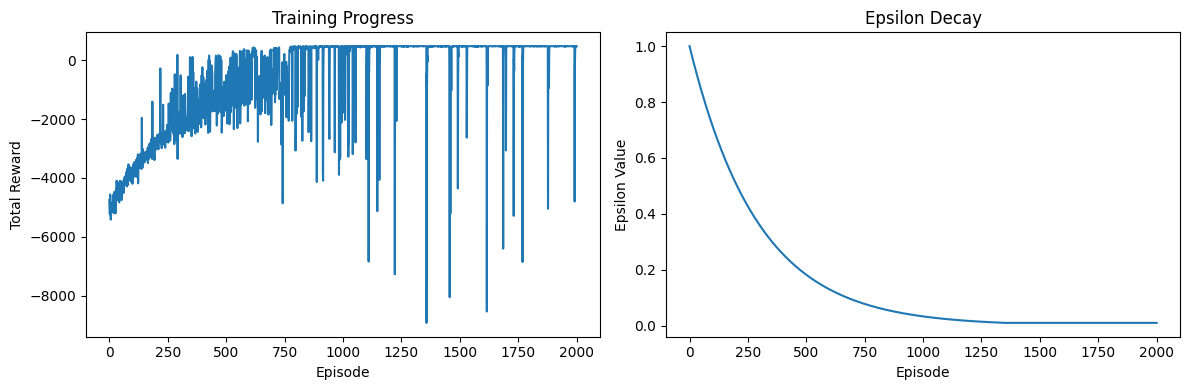

Training Episode 2101/2500
Training Episode 2201/2500
Training Episode 2301/2500
Training Episode 2401/2500

🎉 Training Complete. Trained Q-table:
----------------------------------------------------------------------------------------------------
((0, 0), 0, 0)            [-11.39 -17.02 -17.59  34.8  -23.59 -10.08]                 
((1, 0), 0, 0)            [-10.87 -11.1  -19.26 -19.08 -23.81 -11.1 ]                 
((2, 0), 0, 0)            [ -9.41 -10.8  -18.89 -19.04 -23.61 -10.8 ]                 
((3, 0), 0, 0)            [-10.52 -10.52 -18.61  -6.29 -23.92 -10.52]                 
((3, 1), 0, 0)            [-10.36 -18.71 -10.07  -8.52 -22.74  -9.81]                 
... (truncated for brevity, full table saved to file)
-------------------------------------------------------------------------------------


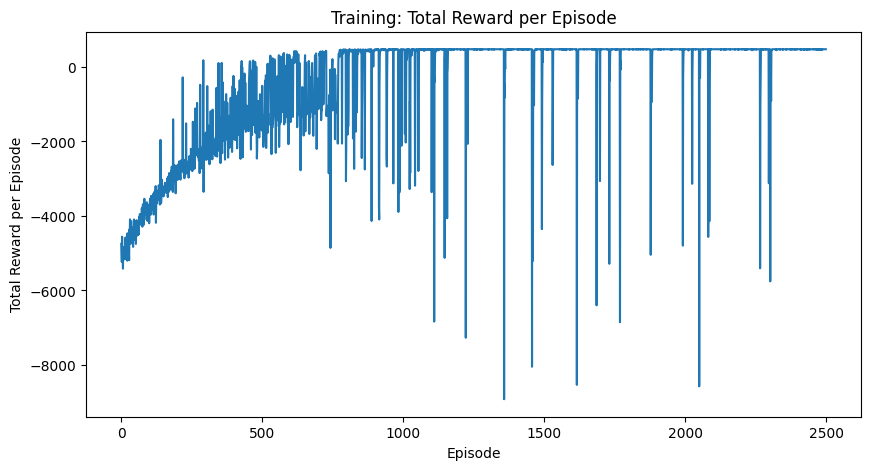

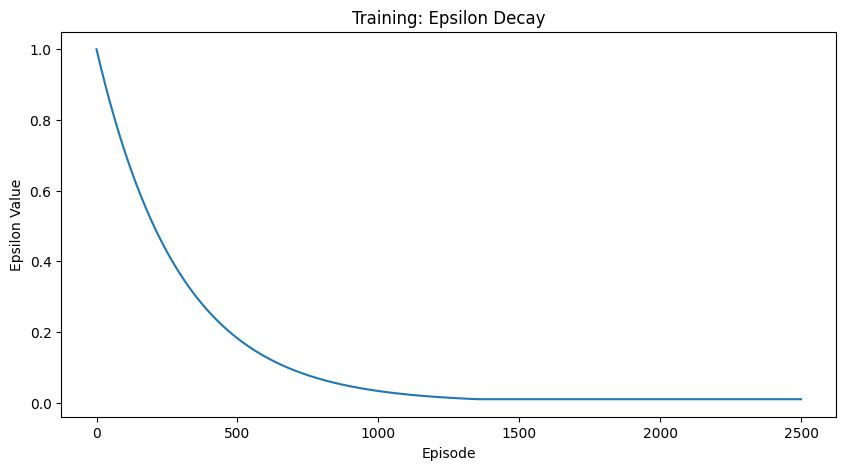

Evaluation Episode 1: Total Reward = 474
Evaluation Episode 2: Total Reward = 474
Evaluation Episode 3: Total Reward = 474
Evaluation Episode 4: Total Reward = 474
Evaluation Episode 5: Total Reward = 474
Evaluation Episode 6: Total Reward = 474
Evaluation Episode 7: Total Reward = 474
Evaluation Episode 8: Total Reward = 474
Evaluation Episode 9: Total Reward = 474
Evaluation Episode 10: Total Reward = 474


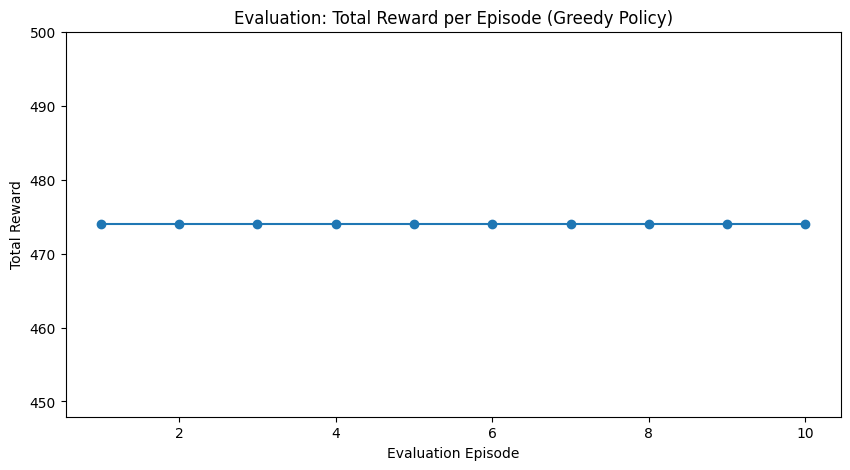

In [30]:
# Define the environment (assuming DeterministicWarehouseRobotEnv is defined elsewhere)
env = DeterministicWarehouseRobotEnv()

# Set up file for saving/loading Q-table
q_table_file = "Deterministic1.pkl"

# Load or train Q-table with beautified Q-table output
if os.path.exists(q_table_file):
    with open(q_table_file, "rb") as f:
        Q_loaded = pickle.load(f)
    print("\n🌟 Loaded Trained Q-table from File:")
    print(f"{'State':<25} {'Action Values':<60}")
    print("-" * 85)  # Separator line for visual clarity
    for state, values in list(Q_loaded.items())[:5]:  # Show first 5 entries for brevity
        print(f"{str(state):<25} {str(np.round(values, decimals=2)):<60}")
    if len(Q_loaded) > 5:
        print("... (truncated for brevity, full table available in file)")
    print("-" * 85)  # Closing separator line
    # For evaluation plotting, we need the training history; here we set them to empty lists
    reward_history = []
    epsilon_history = []
else:
    # Initialize Q and print the initial (empty) Q-table with beautification
    from collections import defaultdict
    initial_Q = defaultdict(lambda: np.zeros(env.action_space.n))
    print("\n🆕 Initial Q-table (should be empty as no states have been visited yet):")
    print("-" * 100)  # Separator line for visual clarity
    for state, values in list(dict(initial_Q).items())[:5]:  # Show first 5 entries for brevity
        print(f"{str(state):<25} {str(np.round(values, decimals=2)):<60}")
    if len(initial_Q) > 5:
        print("... (empty table, will train now)")
    print("-" * 85)  # Closing separator line

    print("\n🚀 Training Q-learning Agent...")
    # Assuming train_q_learning is defined elsewhere
    Q_loaded, reward_history, epsilon_history = train_q_learning(
        env, episodes=2500, alpha = 0.0176, gamma=0.9492, epsilon_decay=0.9966
    )
    # Print trained Q-table with beautification
    print("\n🎉 Training Complete. Trained Q-table:")
    print("-" * 100)  # Separator line for visual clarity
    for state, values in list(dict(Q_loaded).items())[:5]:  # Show first 5 entries for brevity
        print(f"{str(state):<25} {str(np.round(values, decimals=2)):<60}")
    if len(Q_loaded) > 5:
        print("... (truncated for brevity, full table saved to file)")
    print("-" * 85)  # Closing separator line

    # Save the trained Q-table to file
    with open(q_table_file, "wb") as f:
        pickle.dump(dict(Q_loaded), f)

    # Plot total reward per episode
    plt.figure(figsize=(10, 5))
    plt.plot(reward_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward per Episode")
    plt.title("Training: Total Reward per Episode")
    plt.show()

    # Plot epsilon decay graph
    plt.figure(figsize=(10, 5))
    plt.plot(epsilon_history)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon Value")
    plt.title("Training: Epsilon Decay")
    plt.show()

# Record a video of the agent's performance (using greedy actions)
video_html = record_video_inline(env, Q_loaded)

# --------------------------------
# Evaluation with Greedy Policy
# --------------------------------
num_eval_episodes = 10
eval_rewards = []

for ep in range(num_eval_episodes):
    state, _ = env.reset()
    total_reward = 0
    steps = 0
    done = False
    while not done and steps < 1000:
        # Always choose the greedy action
        action = np.argmax(Q_loaded[state])
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        state = next_state
        steps += 1
    eval_rewards.append(total_reward)
    print(f"Evaluation Episode {ep+1}: Total Reward = {total_reward}")

# Plot evaluation rewards
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_eval_episodes + 1), eval_rewards, marker='o')
plt.xlabel("Evaluation Episode")
plt.ylabel("Total Reward")
plt.title("Evaluation: Total Reward per Episode (Greedy Policy)")
plt.show()
display(video_html)

# STOCHASTIC


Stochastic Simulation:
Initial Grid:


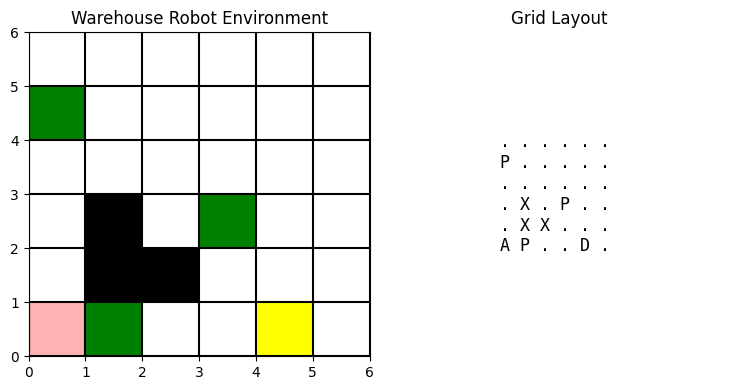

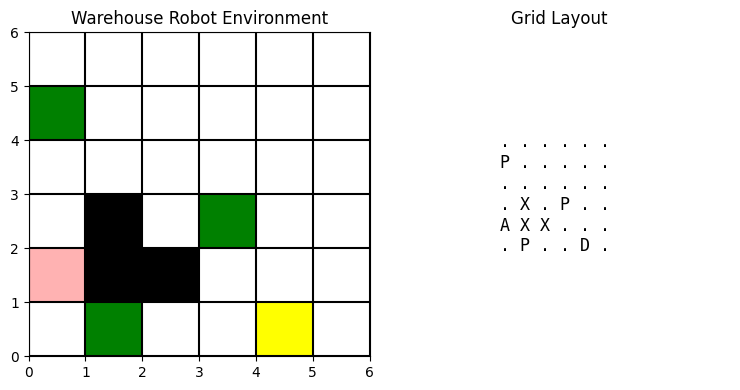

Step: 1
Action: 0 (Up)
Reward: -1
Cumulative Reward: -1
Agent Position: (1, 0)
Has Picked Up: False



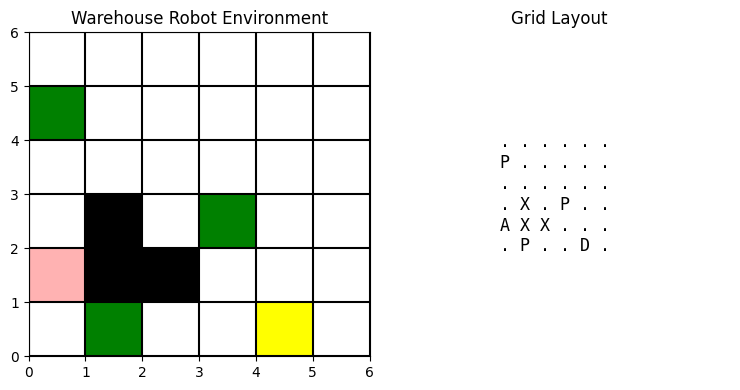

Step: 2
Action: 4 (Pickup)
Reward: -5
Cumulative Reward: -6
Agent Position: (1, 0)
Has Picked Up: False



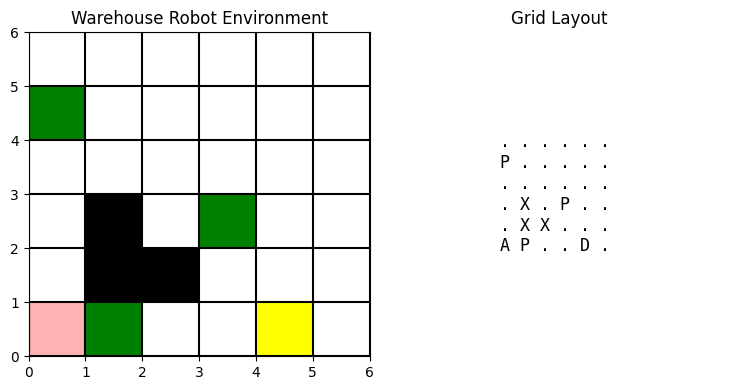

Step: 3
Action: 1 (Down)
Reward: -1
Cumulative Reward: -7
Agent Position: (0, 0)
Has Picked Up: False



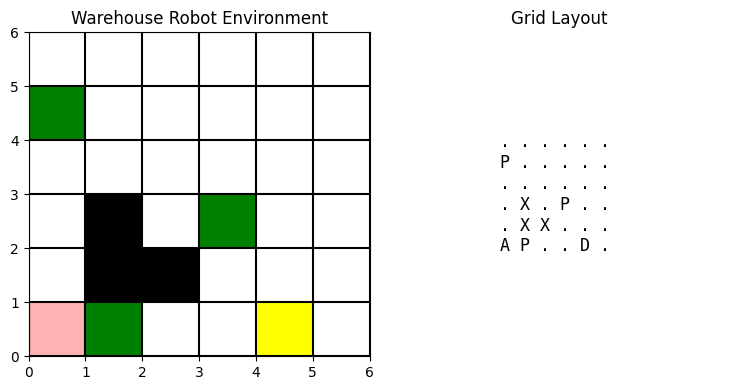

Step: 4
Action: 5 (Dropoff)
Reward: -5
Cumulative Reward: -12
Agent Position: (0, 0)
Has Picked Up: False



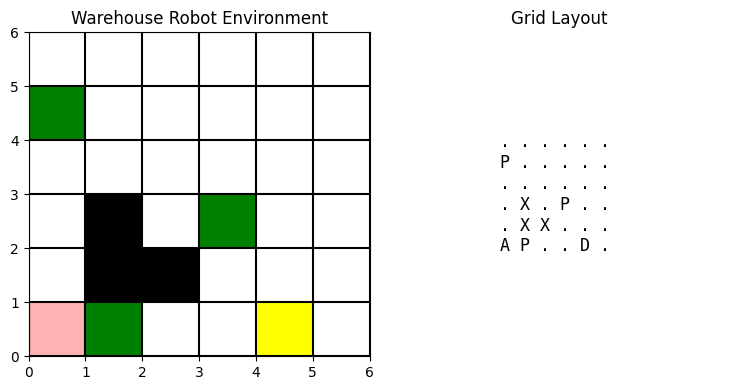

Step: 5
Action: 1 (Down)
Reward: -15
Cumulative Reward: -27
Agent Position: (0, 0)
Has Picked Up: False



In [6]:
# Run stochastic simulation
print("\nStochastic Simulation:")
run_simulation(deterministic=False, num_steps=5)